# Remote Sensing - Exploring Black Marble Imagery at Penn State

## Environment Setup

### Import Packages

In [8]:
# Import packages
import os
import re
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.transform import from_origin
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.mask as em

### Set Package Options

In [9]:
# Set options
sns.set(font_scale=1.5)
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Define Functions

In [61]:
def get_radiance_data(radiance_df, year, month, day=None):
    """Returns a list of single-day radiance dataframes
    based on the specified month and year.

    YYYY-MM-DD

    Parameters
    ----------
    radiance_df : pandas dataframe
        Dataframe indexed by pixel ID containing the 
        radiance data by date (columns).

    year : str
        Four-digit year (YYYY).

    month : str
        Two-digit month (MM), with leading 0s
        (ex: 01, 02, 03, 10).

    day : str
        One (M) or two-digit (MM) month, with
        leading 0s (ex: 01, 02, 03, 10).

    Returns
    -------

    Example
    -------
        >>> radience_data = get_radiance_data(radiance_df, year='2019', month='09')
        >>>
        >>>
        >>>
    """
    # Get radiance value dataframes into list
    radiance = [radiance_df[[col]]
                for col in radiance_df.columns
                if re.compile(f"^{year}-{month}-(0[1-9]|[12]\d|3[01])$").match(col)]

    return radiance

In [62]:
def get_cloud_mask_data(cloud_mask_df, year, month, day=None):
    """Returns a list of single-day cloud mask
    dataframes based on the specified month and year.

    M(M)/D(D)/YYYY

    Parameters
    ----------
    cloud_mask_df : pandas dataframe
        Dataframe indexed by pixel ID containing the 
        cloud mask data by date (columns).

    year : str
        Four-digit year (YYYY).

    month : str
        One (M) or two-digit (MM) month, without 
        leading 0s (ex: 1, 2, 3, 10).

    day : str
        One (M) or two-digit (MM) day, without 
        leading 0s (ex: 1, 2, 3, 10).  

    Returns
    -------

    Example
    -------
        >>> mask_data = get_cloud_mask_data(mask_df, year='2019', month='9') 
        >>>
        >>>
        >>>
    """
    # Get cloud mask value dataframes into list
    cloud_mask = [cloud_mask_df[[col]]
                  for col in cloud_mask_df.columns
                  if re.compile(f"^{month}/([1-9]|[12]\d|3[01])/{year}$").match(col)]

    return cloud_mask

In [10]:
def get_psu_array(radiance_data):
    """Extracts radiance and cloud mask data into a 
    correctly-shaped array for the Penn State campus.
    
    Meant for specific use with the Penn State campus data.
    
    Parameters
    ----------
    radiance_data : pandas dataframe
        Dataframe containing the radiance data
        (radiance values or cloud mask values).
    
    Returns
    -------
    N/A : numpy array
        Numpy array containg the formatted radiance data
        (radiance values or cloud mask values).
    
    Example
    ------
        >>> import pandas as pd 
        >>> radiance_df = pd.read_csv(radiance_path)
        >>> radiance_arr = get_psu_array(radiance_df)
    """
    # Convert dataframe to numpy array, reshape array, and transpose array
    return radiance_data.to_numpy().reshape((40,18)).transpose()

In [11]:
def calculate_mean_radiance(radiance_data, cloud_mask_data):
    """
    Parameters
    ----------
    radiance_data : list (of pandas dataframes)
        List containing individual day radiance values
        for all pixels in the study area.

    cloud_mask_data : list (of pandas dataframes)
        List containing individual day cloud mask 
        values for all pixels in the study area.

    Returns
    -------
    mean_radiance : numpy array (possibly masked)
        Numpy array containing mean radiance values
        for the study area, over the time period of
        the input data.
        
    Example
    -------
        >>>
        >>>
        >>>
        >>>
    """
    # Create lists of numpy arrays from lists of dataframes
    radiance_arrays = list(map(get_psu_array, radiance_data))
    cloud_mask_arrays = list(map(get_psu_array, cloud_mask_data))

    # Zip lists together to match up (tuple) radiance value array with cloud mask array
    zipped_arrays = list(zip(radiance_arrays, cloud_mask_arrays))

    # Create list of masked arrays (based on data/mask tuples)
    # Initialize list
    radiance_masked_arrays = []

    # Loop through each tuple
    for radiance_mask_tuple in zipped_arrays:

        # Check if array should be masked (includes mask value)
        if 100 in radiance_mask_tuple[1]:

            # Mask with clouad mask value
            radiance_cloud_free = em.mask_pixels(
                radiance_mask_tuple[0],
                radiance_mask_tuple[1],
                vals=[100])

            # Append masked array to list of arrays
            radiance_masked_arrays.append(radiance_cloud_free)

        # If no mask value
        else:

            # Append original (cloud-free) array to list of arrays
            radiance_masked_arrays.append(radiance_mask_tuple[0])

    # Create stack of numpy arrays (3d array) of cloud free data
    radiance_masked_stack = np.stack(radiance_masked_arrays)
    
    # Get mean value for each pixel, over all arrays (bands)
    radiance_masked_stack_mean = np.mean(radiance_masked_stack, axis=0)
    
    # Return mean
    return radiance_masked_stack_mean

In [12]:
def export_to_geotiff(array, output_path, metadata):
    """Exports a numpy array to a GeoTiff.

    Parameters
    ----------
    array : numpy array
        Numpy array to be exported to GeoTiff.

    output_path : str
        Path to the output file (includeing filename).

    metadata : dict
        Dictionary containing the metadata required 
        for export.

    Returns
    -------
    N/A : str
        Message indicating success or failure or export.

    Example
    -------
        >>>
        >>>
        >>>
        >>>
    """
    try:
        # Write numpy array to GeoTiff
        with rio.open(output_path, 'w', **metadata) as dst:
            dst.write(array, 1)

    except Exception as error:
        message = f"ERROR: {error}"

    else:
        message = f"Exported {output_path}"

    return print(message)

### Set Working Directory

In [13]:
# Set working directory
working_directory = os.path.join(
    et.io.HOME, "PSU", "08-covid19-remote-sensing-fusion",
    "00-git-repos", "penn-state-radiance")

## Data Preparation

### Define File Paths

In [14]:
# Set path to radiance files
radiance_directory = os.path.join(
    working_directory, "02-raw-data", "radiance_files")

psu_lat_lon_path = os.path.join(
    radiance_directory, "PSU_Pixel_LatLongs.csv")

psu_radiance_path = os.path.join(
    radiance_directory, "PSU_Radiance_RavelOrderF.csv")

psu_cloud_mask_path = os.path.join(
    radiance_directory, "PSU_CloudMask_RavelOrderF.csv")

In [15]:
# Check that all paths to files exist
for path in [psu_lat_lon_path, psu_radiance_path, psu_cloud_mask_path]:
    print(f"Path exists: {path}") if os.path.exists(
        path) else print(f"Path does not exist: {path}")

Path exists: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\02-raw-data\radiance_files\PSU_Pixel_LatLongs.csv
Path exists: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\02-raw-data\radiance_files\PSU_Radiance_RavelOrderF.csv
Path exists: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\02-raw-data\radiance_files\PSU_CloudMask_RavelOrderF.csv


### Read CSV Files to Geodataframes

In [16]:
# Read lat/lon into dataframe
psu_lat_lon_df = pd.read_csv(psu_lat_lon_path)

In [17]:
# Display dataframe
psu_lat_lon_df.head()

,ID,Latitude,Longitude
0,0,40.829917,-77.937355
1,1,40.825751,-77.937355
2,2,40.821584,-77.937355
3,3,40.817417,-77.937355
4,4,40.813251,-77.937355


In [18]:
# Read radiance values to dataframe
psu_radiance_df = pd.read_csv(psu_radiance_path)

In [19]:
psu_radiance_df.head()

,2019-09-01,2019-09-02,2019-09-03,2019-09-04,2019-09-05,2019-09-06,2019-09-07,2019-09-08,2019-09-11,2019-09-12,2019-09-13,2019-09-14,2019-09-15,2019-09-17,2019-09-18,2019-09-19,2019-09-20,2019-09-22,2019-09-23,2019-09-25,2019-09-26,2019-09-27,2019-09-28,2019-10-01,2019-10-02,2019-10-04,2019-10-05,2019-10-06,2019-10-08,2019-10-09,2019-10-10,2019-10-11,2019-10-12,2019-10-13,2019-10-14,2019-10-15,2019-10-17,2019-10-18,2019-10-19,2019-10-20,2019-10-21,2019-10-22,2019-10-23,2019-10-24,2019-10-25,2019-10-26,2019-10-27,2019-10-28,2019-10-30,2019-11-01,2019-11-02,2019-11-03,2019-11-05,2019-11-06,2019-11-08,2019-11-09,2019-11-10,2019-11-11,2019-11-14,2019-11-15,2019-11-16,2019-11-17,2019-11-18,2019-11-19,2019-11-21,2019-11-22,2019-11-23,2019-11-24,2019-11-25,2019-11-27,2019-11-28,2019-11-29,2019-12-01,2019-12-02,2019-12-03,2019-12-04,2019-12-05,2019-12-06,2019-12-07,2019-12-08,2019-12-09,2019-12-10,2019-12-11,2019-12-12,2019-12-13,2019-12-14,2019-12-15,2019-12-16,2019-12-17,2019-12-20,2019-12-21,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-11,2020-01-12,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-25,2020-04-26,2020-04-27,2020-04-28
0,12,6,9,7,14,7,7,16,10,35,103,194,34,38,22,22,24,11,88,6,10,9,11,7,10,8,6,15,9,47,11,22,33,37,86,41,110,73,20,57,25,16,14,8,146,24,7,9,10,12,10,10,19,7,14,19,46,148,116,34,98,29,52,24,13,11,13,3,7,21,16,19,16,33,17,5,14,27,18,33,86,92,176,132,116,185,155,70,68,21,18,17,8,25,6,11,12,11,25,9,8,14,10,9,12,11,17,45,88,116,157,254,225,57,70,18,30,36,24,20,22,17,23,53,9,25,7,13,8,11,14,7,11,4,35,67,61,227,353,294,152,43,82,41,10,30,12,7,10,10,12,12,6,6,16,13,17,16,15,8,10,13,13,15,18,122,38,95,189,33,47,65,17,23,11,6,11,6,3,10,9,6,7,1,6,5,10,6,24,7,9,6,4,14
1,11,6,9,7,14,15,11,16,18,44,103,194,34,45,22,32,24,13,88,27,18,9,11,9,10,18,25,15,9,47,24,22,37,39,86,41,113,73,20,61,25,16,22,13,146,28,7,15,12,12,20,29,20,16,20,18,51,151,116,102,104,44,52,24,22,11,13,3,12,21,22,19,16,33,27,4,17,27,18,41,100,95,190,132,123,175,155,70,71,28,19,17,7,25,8,17,17,11,25,9,9,20,81,9,10,19,17,47,88,119,157,242,233,57,76,26,35,50,25,31,43,17,29,56,10,23,9,20,16,11,21,7,11,59,35,62,62,227,353,293,159,44,83,40,10,34,12,7,10,15,12,12,17,9,18,14,17,16,26,54,20,16,13,29,30,124,41,95,189,45,50,66,18,24,11,8,12,6,3,10,22,7,7,1,13,5,10,7,24,10,14,4,7,17
2,11,6,17,18,35,60,11,15,18,41,105,197,50,98,42,32,31,14,31,27,44,18,85,7,18,16,25,17,15,24,24,48,51,133,86,36,109,73,20,61,35,14,19,23,16,28,7,15,12,19,20,31,20,46,20,18,75,153,118,102,104,44,58,31,18,19,29,3,16,27,29,30,17,35,41,4,17,34,25,41,100,96,189,133,133,175,147,74,69,32,29,19,7,15,31,17,17,14,36,5,11,21,81,9,10,19,19,47,98,162,158,242,239,89,76,26,35,50,25,89,43,81,29,56,10,25,9,20,16,40,21,7,14,27,42,62,62,243,359,293,160,48,83,43,18,34,12,7,31,19,25,38,17,9,18,14,19,26,26,54,36,16,16,154,92,132,44,96,193,45,61,66,91,25,23,9,12,4,6,12,22,9,18,2,20,7,9,7,40,11,15,4,7,17
3,11,7,66,95,35,60,116,15,135,54,105,202,168,98,106,108,62,97,92,116,44,166,181,17,59,15,57,17,15,24,50,29,44,133,86,36,109,73,176,66,72,14

In [20]:
# Read cloud mask values to dataframe
psu_cloud_mask_df = pd.read_csv(psu_cloud_mask_path)

In [21]:
psu_cloud_mask_df.head()

,9/1/2019,9/2/2019,9/3/2019,9/4/2019,9/5/2019,9/6/2019,9/7/2019,9/8/2019,9/11/2019,9/12/2019,9/13/2019,9/14/2019,9/15/2019,9/17/2019,9/18/2019,9/19/2019,9/20/2019,9/22/2019,9/23/2019,9/25/2019,9/26/2019,9/27/2019,9/28/2019,10/1/2019,10/2/2019,10/4/2019,10/5/2019,10/6/2019,10/8/2019,10/9/2019,10/10/2019,10/11/2019,10/12/2019,10/13/2019,10/14/2019,10/15/2019,10/17/2019,10/18/2019,10/19/2019,10/20/2019,10/21/2019,10/22/2019,10/23/2019,10/24/2019,10/25/2019,10/26/2019,10/27/2019,10/28/2019,10/30/2019,11/1/2019,11/2/2019,11/3/2019,11/5/2019,11/6/2019,11/8/2019,11/9/2019,11/10/2019,11/11/2019,11/14/2019,11/15/2019,11/16/2019,11/17/2019,11/18/2019,11/19/2019,11/21/2019,11/22/2019,11/23/2019,11/24/2019,11/25/2019,11/27/2019,11/28/2019,11/29/2019,12/1/2019,12/2/2019,12/3/2019,12/4/2019,12/5/2019,12/6/2019,12/7/2019,12/8/2019,12/9/2019,12/10/2019,12/11/2019,12/12/2019,12/13/2019,12/14/2019,12/15/2019,12/16/2019,12/17/2019,12/20/2019,12/21/2019,12/22/2019,12/23/2019,12/24/2019,12/25/2019,12/26/2019,12/27/2019,12/28/2019,12/29/2019,12/30/2019,12/31/2019,1/1/2020,1/2/2020,1/3/2020,1/4/2020,1/5/2020,1/6/2020,1/7/2020,1/8/2020,1/9/2020,1/10/2020,1/11/2020,1/12/2020,1/13/2020,1/14/2020,1/15/2020,1/16/2020,1/17/2020,1/18/2020,1/19/2020,1/20/2020,1/21/2020,1/22/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,1/29/2020,1/30/2020,1/31/2020,2/1/2020,2/2/2020,2/3/2020,2/4/2020,2/5/2020,2/6/2020,2/8/2020,2/9/2020,2/10/2020,2/11/2020,2/12/2020,2/13/2020,2/14/2020,2/15/2020,2/16/2020,2/17/2020,2/18/2020,2/19/2020,2/20/2020,2/21/2020,2/22/2020,2/23/2020,2/24/2020,2/25/2020,2/26/2020,2/27/2020,2/28/2020,2/29/2020,3/1/2020,3/2/2020,3/3/2020,3/4/2020,3/5/2020,3/6/2020,3/7/2020,3/8/2020,3/9/2020,3/10/2020,3/11/2020,3/12/2020,3/13/2020,3/14/2020,3/15/2020,3/16/2020,3/17/2020,3/18/2020,3/19/2020,3/20/2020,3/21/2020,3/22/2020,3/23/2020,3/24/2020,3/25/2020,3/26/2020,3/27/2020,3/28/2020,3/29/2020,3/30/2020,3/31/2020,4/25/2020,4/26/2020,4/27/2020,4/28/2020
0,100,100,1,1,1,1,1,1,1,100,100,100,1,100,1,1,100,1,1,1,1,1,1,100,1,1,1,100,100,100,1,1,100,1,1,1,100,100,1,100,100,100,1,1,1,100,100,1,100,100,1,1,100,1,1,1,100,100,100,1,100,1,100,100,1,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100,100,100,100,1,100,100,100,100,100,100,100,1,1,1,1,1,100,100,100,100,100,100,1,100,100,1,100,100,100,1,100,100,100,100,100,1,100,100,100,100,1,1,1,100,100,100,100,100,100,1,100,100,100,1,100,100,100,100,100,100,100,100,100,100,1,100,100,100,100,1,1,1,1,1,100,1,100,1,100,1,1,100,1,100,1,100,1,100,100,1,100,100,1,100,1,100,100,100,100,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100
1,100,100,1,1,1,1,1,1,1,100,100,100,1,100,1,1,100,1,1,1,1,1,1,100,1,1,1,100,100,100,1,1,100,1,1,1,100,100,1,100,100,100,1,1,1,100,100,1,100,100,1,1,100,1,1,1,100,100,100,1,100,1,100,100,1,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100,100,100,100,1,100,100,100,100,100,100,100,1,1,1,1,100,100,100,100,100,100,100,1,100,100,1,100,100,100,100,100,100,100,100,100,1,100,1,100,1,1,1,1,100,100,100,100,100,100,1,100,100,100,1,100,100,100,100,100,100,100,100,100,100,1,100,100,100,100,1,1,1,1,1,100,1,100,1,100,1,1,100,100,100,1,100,1,100,100,1,100,100,1,100,1,100,100,100,100,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100
2,100,100,1,1,1,1,1,1,1,100,100,100,1,1,1,1,100,1,1,1,1,1,1,100,1,1,1,100,100,100,1,1,100,1,1,1,100,100,1,100,100,100,1,1,1,100,100,1,100,100,1,1,100,1,1,1,100,100,100,1,100,1,100,100,1,100,1,100,100,100,100,100,100,100,1,100,100,100,1,100,100,100,100,1,100,100,100,100,100,100,100,1,1,1,1,100,100,100,100,100,100,100,1,100,100,1,100,100,1,100,100,100,100,1,100,1,100,100,100,1,1,1,1,100,100,100,100,100,100,1,100,100,100,1,100,100,100,100,100,100,100,100,100,100,1,100,100,100,100,1,1,1,1,1,100,1,100,1,1,1,1,100,100,1,1,100,1,100,100,1,100,100,1,100,1,100,100,100,100,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100
3,100,100,1,1,1,1,1,1,1,100,100,100,1,1,1,1,100,1,1,1,1,1,1,100,1,1,1,100,100,100,1,1,100,1,1,1,100,100,1,100,100,100,1,1,1,100,100,1,100,100,

### Create Plotting Extent

In [22]:
# Get min/max longitude and latitude values
lon_min = psu_lat_lon_df.Longitude.min()
lon_max = psu_lat_lon_df.Longitude.max()
lat_min = psu_lat_lon_df.Latitude.min()
lat_max = psu_lat_lon_df.Latitude.max()

In [23]:
# Display values
print(f"Lon min: {lon_min}\nLon max: {lon_max}\nLat min: {lat_min}\nLat max: {lat_max}")

Lon min: -77.93735504
Lon max: -77.77485504
Lat min: 40.75908399
Lat max: 40.82991733


In [24]:
# Get spacing for extent (assume lat/lon are centroids)
lon_spacing = (lon_max - lon_min) / 39
lat_spacing = (lat_max - lat_min) / 17

# Check to which decimal the lat and long spacings match
round(lon_spacing, 9) == round(lon_spacing, 9)

# Define single spacing
coord_spacing = round(lon_spacing, 9)

In [25]:
# Define extent
psu_extent = (
    lon_min - coord_spacing/2,
    lon_max + coord_spacing/2,
    lat_min - coord_spacing/2,
    lat_max + coord_spacing/2
)

In [26]:
# # Define extent
# psu_extent = (lon_min-0.004166999999995369/2, 
#               lon_max+0.004166999999995369/2, 
#               lat_min-0.004166999999995369/2, 
#               lat_max+0.004166999999995369/2)

In [27]:
# Show extent (xmin, xmax, ymin, ymax)
psu_extent

(-77.9394383735, -77.77277170650001, 40.7570006565, 40.832000663500004)

In [28]:
# Create geodataframe to store lat/lon points 
#  (for plotting over array)
psu_lat_lon_copy = psu_lat_lon_df.copy()

psu_lat_lon_gdf = gpd.GeoDataFrame(
    psu_lat_lon_copy, 
    crs="epsg:4326", 
    geometry=gpd.points_from_xy(
        psu_lat_lon_copy.Longitude, 
        psu_lat_lon_copy.Latitude)
)

In [29]:
# Display dataframe
psu_lat_lon_gdf.head()

,ID,Latitude,Longitude,geometry
0,0,40.829917,-77.937355,POINT (-77.93736 40.82992)
1,1,40.825751,-77.937355,POINT (-77.93736 40.82575)
2,2,40.821584,-77.937355,POINT (-77.93736 40.82158)
3,3,40.817417,-77.937355,POINT (-77.93736 40.81742)
4,4,40.813251,-77.937355,POINT (-77.93736 40.81325)


## Data Processing

Store all this in a dictionary, indexed by year and then month? Nested dictionaries. Do this by looping through list of tuples (YEAR, MONTH) for the get data function? Same for mean? 

### Calculate Mean Radiance for September 2019


In [68]:
# Get Sept 2019 radiance value dataframes into list
sept_2019_radiance = get_radiance_data(
    psu_radiance_df, year='2019', month='09')

# Get Sept 2019 cloud mask dataframes into list
sept_2019_mask = get_cloud_mask_data(
    psu_cloud_mask_df, year='2019', month='9')

In [70]:
# Calculate mean radiance
sept_2019_mean_radiance = calculate_mean_radiance(
    sept_2019_radiance, sept_2019_mask)

In [71]:
# Display shape of array (should be 18 rows, 40 columns)
sept_2019_mean_radiance.shape

(18, 40)

### Calculate Mean Radiance for October 2019


In [78]:
# Get Oct 2019 radiance value dataframes into list
oct_2019_radiance = get_radiance_data(
    psu_radiance_df, year='2019', month='10')

# Get Sept 2019 cloud mask dataframes into list
oct_2019_mask = get_cloud_mask_data(
    psu_cloud_mask_df, year='2019', month='10')

In [81]:
# Calculate mean radiance
oct_2019_mean_radiance = calculate_mean_radiance(
    oct_2019_radiance, oct_2019_mask)

In [82]:
# Display shape of array (should be 18 rows, 40 columns)
oct_2019_mean_radiance.shape

(18, 40)

### Calculate Mean Radiance for November 2019


In [91]:
# Get Nov 2019 radiance value dataframes into list
nov_2019_radiance = get_radiance_data(
    psu_radiance_df, year='2019', month='11')

# Get Nov 2019 cloud mask dataframes into list
nov_2019_mask = get_cloud_mask_data(
    psu_cloud_mask_df, year='2019', month='11')

In [92]:
# Calculate mean radiance
nov_2019_mean_radiance = calculate_mean_radiance(
    nov_2019_radiance, nov_2019_mask)

In [93]:
# Display shape of array (should be 18 rows, 40 columns)
nov_2019_mean_radiance.shape

(18, 40)

### Calculate Mean Radiance for December 2019


In [102]:
# Get Dec 2019 radiance value dataframes into list
dec_2019_radiance = get_radiance_data(
    psu_radiance_df, year='2019', month='12')

# Get Nov 2019 cloud mask dataframes into list
dec_2019_mask = get_cloud_mask_data(
    psu_cloud_mask_df, year='2019', month='12')

In [103]:
# Calculate mean radiance
dec_2019_mean_radiance = calculate_mean_radiance(
    dec_2019_radiance, dec_2019_mask)

In [105]:
# Display shape of array (should be 18 rows, 40 columns)
dec_2019_mean_radiance.shape

(18, 40)

### Calculate Mean Radiance for January 2020


In [110]:
# Get Jan 2020 radiance value dataframes into list
jan_2020_radiance = get_radiance_data(
    psu_radiance_df, year='2020', month='01')

# Get Nov 2019 cloud mask dataframes into list
jan_2020_mask = get_cloud_mask_data(
    psu_cloud_mask_df, year='2020', month='1')

In [111]:
# Calculate mean radiance
jan_2020_mean_radiance = calculate_mean_radiance(
    jan_2020_radiance, jan_2020_mask)

In [112]:
# Display shape of array (should be 18 rows, 40 columns)
jan_2020_mean_radiance.shape

(18, 40)

### Calculate Mean Radiance for February 2020


In [119]:
# Get Feb 2020 radiance value dataframes into list
feb_2020_radiance = get_radiance_data(
    psu_radiance_df, year='2020', month='02')

# Get Nov 2019 cloud mask dataframes into list
feb_2020_mask = get_cloud_mask_data(
    psu_cloud_mask_df, year='2020', month='2')

In [120]:
# Calculate mean radiance
feb_2020_mean_radiance = calculate_mean_radiance(
    feb_2020_radiance, feb_2020_mask)

In [121]:
# Display shape of array (should be 18 rows, 40 columns)
feb_2020_mean_radiance.shape

(18, 40)

### Calculate Mean Radiance for March 2020


In [63]:
# Get March radiance value dataframes into list
march_2020_radiance = get_radiance_data(
    psu_radiance_df, year='2020', month='03')

# Get March cloud mask dataframes into list
march_2020_mask = get_cloud_mask_data(
    psu_cloud_mask_df, year='2020', month='3')

In [64]:
# Calculate mean radiance
march_2020_mean_radiance = calculate_mean_radiance(
    march_2020_radiance, march_2020_mask )

In [65]:
# Display shape of array (should be 18 rows, 40 columns)
march_2020_mean_radiance.shape

(18, 40)

### Calculate Mean Radiance for April 2020


In [123]:
# Get April 2020 radiance value dataframes into list
apr_2020_radiance = get_radiance_data(
    psu_radiance_df, year='2020', month='04')

# Get Nov 2019 cloud mask dataframes into list
apr_2020_mask = get_cloud_mask_data(
    psu_cloud_mask_df, year='2020', month='4')

In [124]:
# Calculate mean radiance
apr_2020_mean_radiance = calculate_mean_radiance(
    apr_2020_radiance, apr_2020_mask)

In [125]:
# Display shape of array (should be 18 rows, 40 columns)
apr_2020_mean_radiance.shape

(18, 40)

### Calculate Change in Mean Radiance from September 2019 to March 2020


In [75]:
# Calculate difference in mean radiance at each pixel
radiance_diff_sept2019_march2020 = march_2020_mean_radiance - sept_2019_mean_radiance

## Data Visualization

### Plot Cloud Free Mean Radiance Values for September 2019

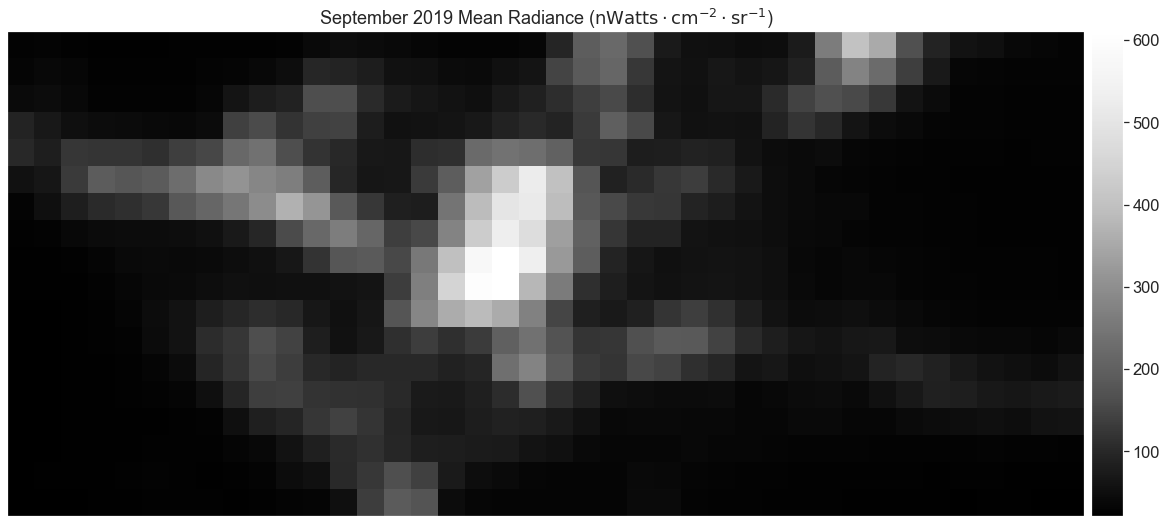

In [30]:
# Create figure and axes object
fig, ax = plt.subplots(figsize=(20, 10))

# Plot radiance values
ep.plot_bands(
    sept_2019_mean_radiance,
    title="September 2019 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
    #cmap='Greens_r',
    scale=False,
    extent=psu_extent, 
    ax=ax,
    vmax=sept_2019_mean_radiance.max())

# Plot lat/lon (centroids)
# psu_lat_lon_gdf.plot(ax=ax)

plt.show()

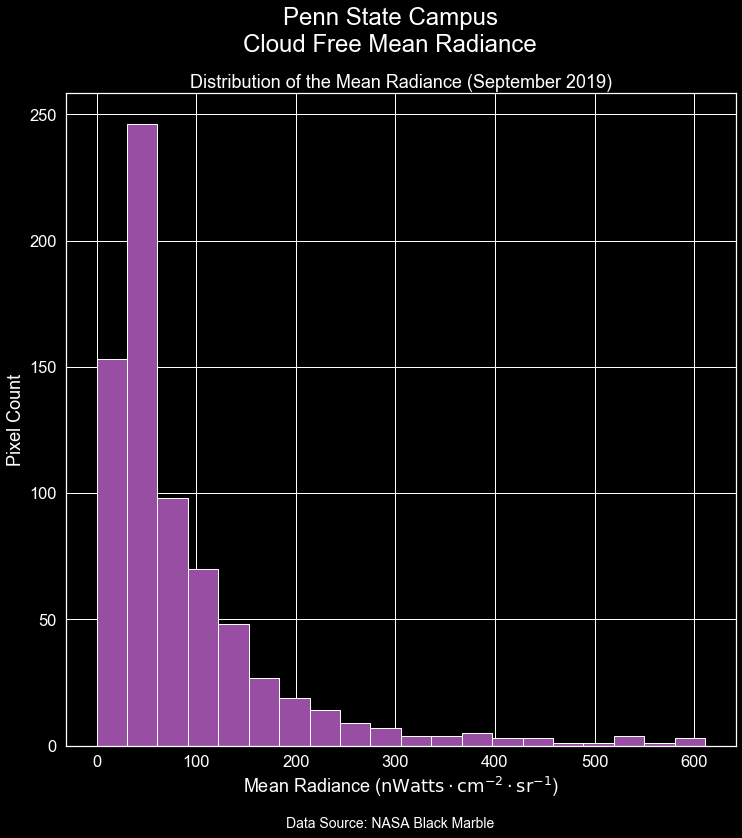

In [31]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        sept_2019_mean_radiance,
        hist_range=(0, sept_2019_mean_radiance.max()),
        colors='#984ea3',
        title='Distribution of the Mean Radiance (September 2019)',
        xlabel='Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)', 
        ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

    plt.show()

### Plot Cloud Free Mean Radiance Values for March 2020

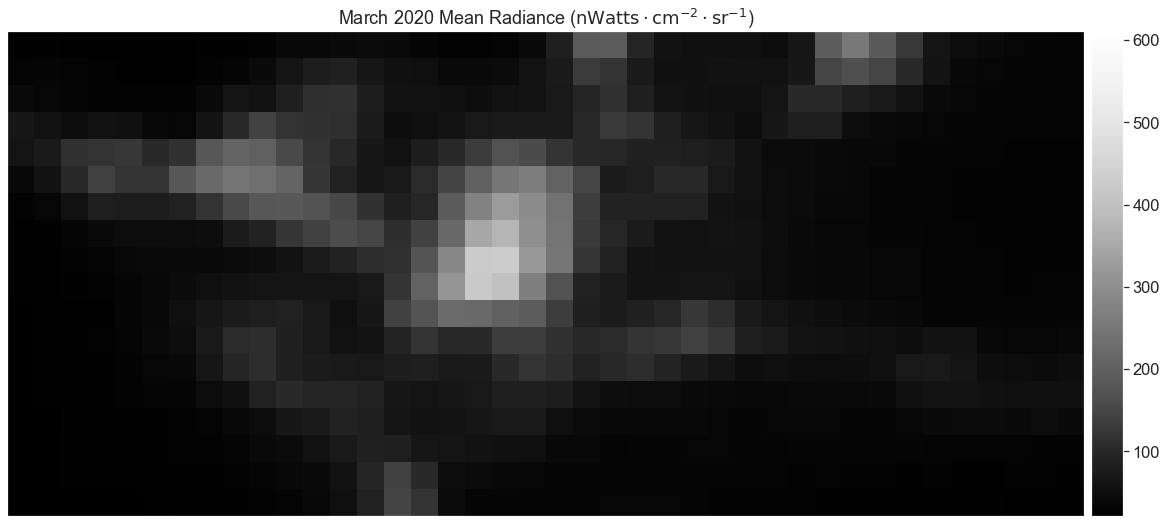

In [32]:
# Create figure and axes object
fig, ax = plt.subplots(figsize=(20, 10))

# Plot with extent
ep.plot_bands(
    march_2020_mean_radiance,
    title="March 2020 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
    #cmap='Greens_r',
    scale=False,
    extent=psu_extent, 
    ax=ax, 
    vmax=sept_2019_mean_radiance.max())

plt.show()

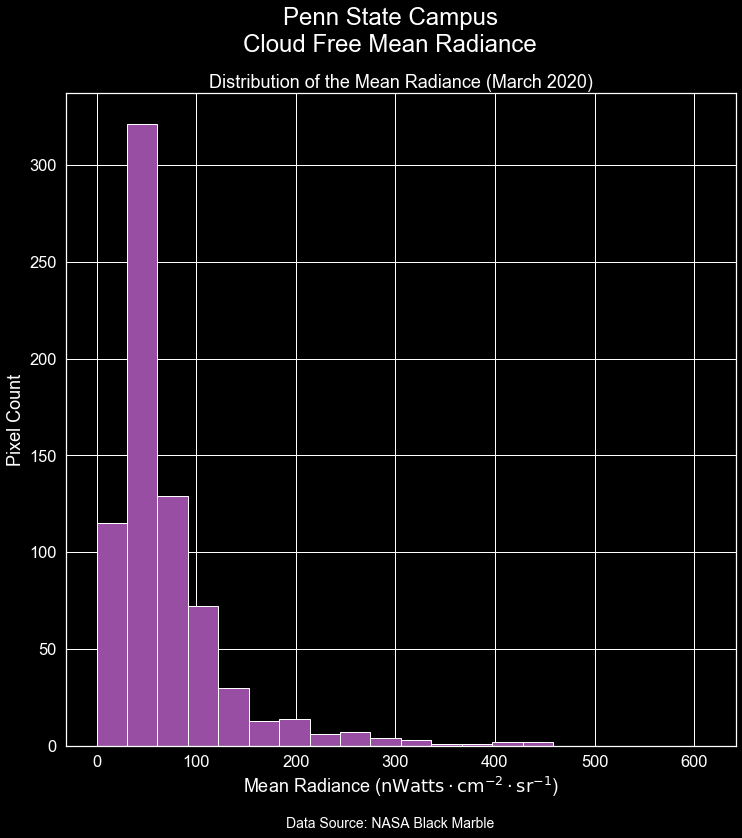

In [33]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        march_2020_mean_radiance,
        hist_range=(0, sept_2019_mean_radiance.max()),
        colors='#984ea3',
        title='Distribution of the Mean Radiance (March 2020)',
        xlabel='Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)',
        ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

    plt.show()

### Plot Cloud Free Change in Mean Radiance Values from September 2019 to March 2020

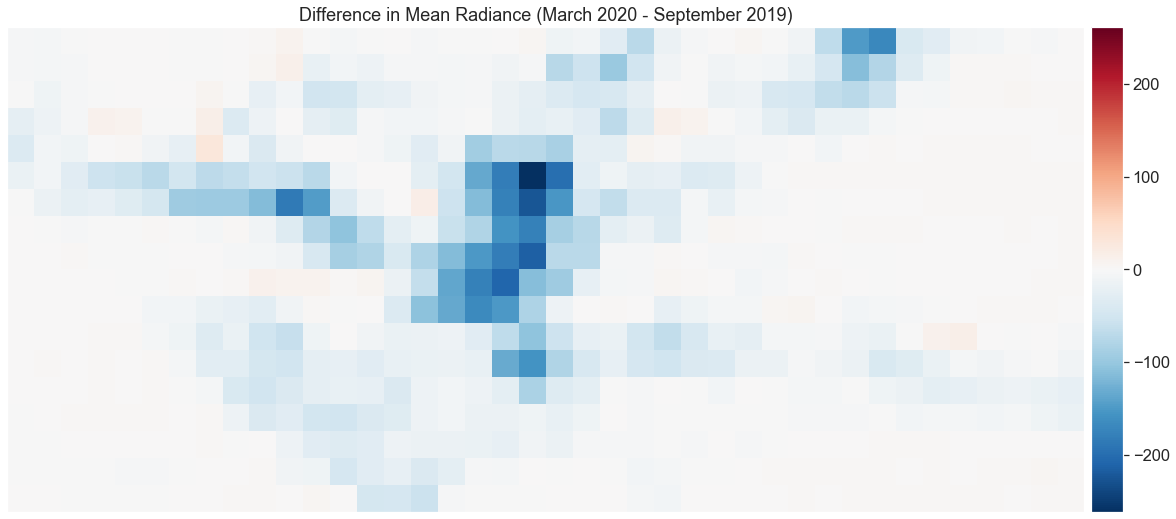

In [34]:
# Plot change in radiance values
ep.plot_bands(
    radiance_diff_sept2019_march2020, 
    title="Difference in Mean Radiance (March 2020 - September 2019)",
    cmap='RdBu_r',
    figsize=(20, 10),
    scale=False,
    vmin=radiance_diff_sept2019_march2020.min(),
    vmax=-radiance_diff_sept2019_march2020.min(),
    extent=psu_extent)

plt.show()

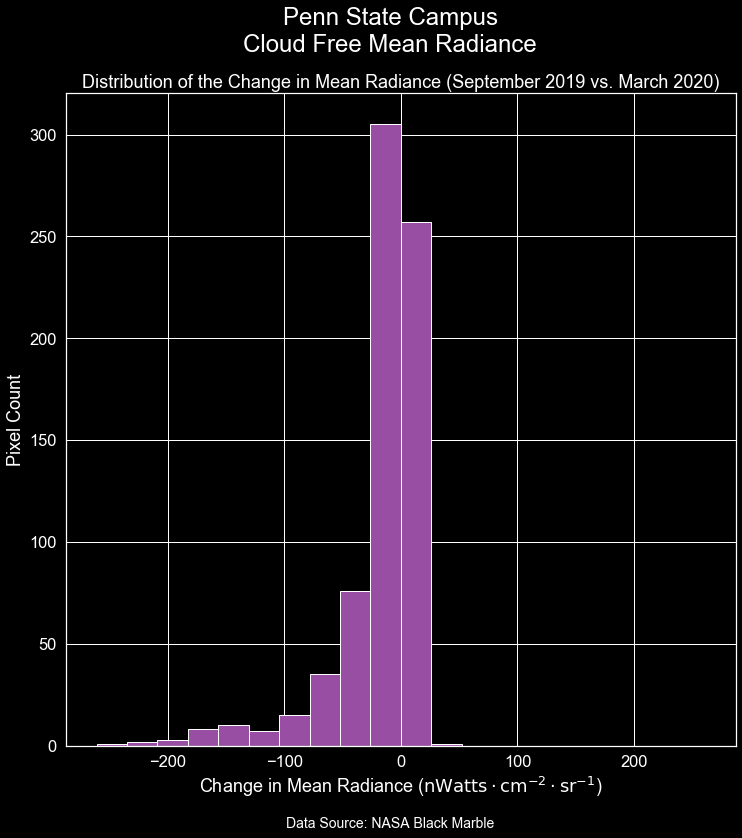

In [35]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        radiance_diff_sept2019_march2020,
        hist_range=(radiance_diff_sept2019_march2020.min(), -radiance_diff_sept2019_march2020.min()),
        colors='#984ea3',
        title='Distribution of the Change in Mean Radiance (September 2019 vs. March 2020)',
        xlabel='Change in Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)', ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

### Combined Plots

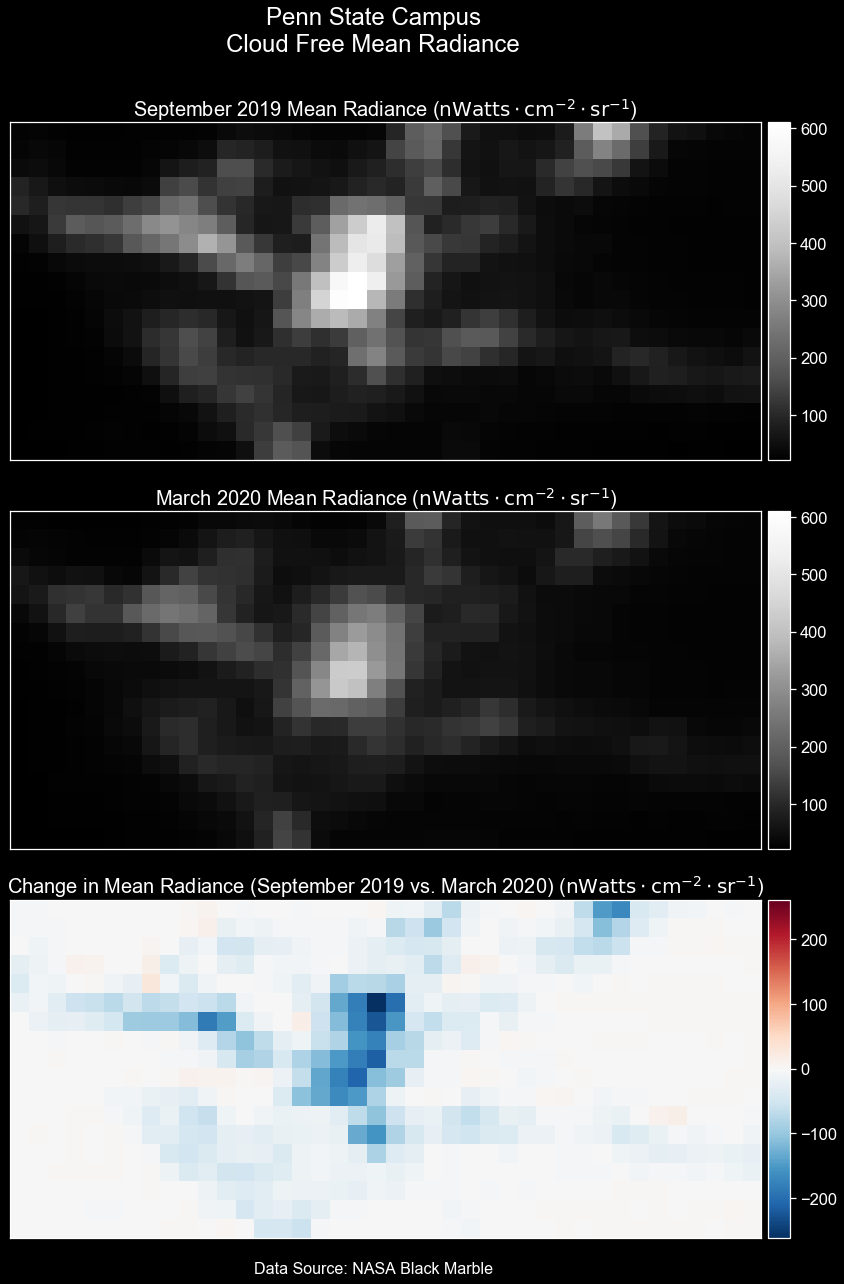

In [36]:
# Plot
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(3, 1, figsize=(30, 20))

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    plt.subplots_adjust(hspace=0.15)
    plt.subplots_adjust(top=0.9)

    ep.plot_bands(
        sept_2019_mean_radiance, title="September 2019 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        scale=False,
        vmax=sept_2019_mean_radiance.max(),
        ax=ax[0],
        extent=psu_extent)

    ep.plot_bands(
        march_2020_mean_radiance, title="March 2020 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        scale=False,
        vmax=sept_2019_mean_radiance.max(),
        ax=ax[1],
        extent=psu_extent)

    ep.plot_bands(
        radiance_diff_sept2019_march2020, title="Change in Mean Radiance (September 2019 vs. March 2020) ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        cmap='RdBu_r',
        scale=False,
        vmin=radiance_diff_sept2019_march2020.min(),
        vmax=-radiance_diff_sept2019_march2020.min(),
        ax=ax[2],
        extent=psu_extent)

    # Add caption
    fig.text(0.5, .1, "Data Source: NASA Black Marble",
             ha='center', fontsize=16)
    
    ax[0].title.set_size(20)
    ax[1].title.set_size(20)
    ax[2].title.set_size(20)

plt.savefig(
    fname="penn-state-mean-radiance-change-sept2019-mar2020-values.png", 
    facecolor='k', dpi=300, transparent=True, bbox_inches='tight')

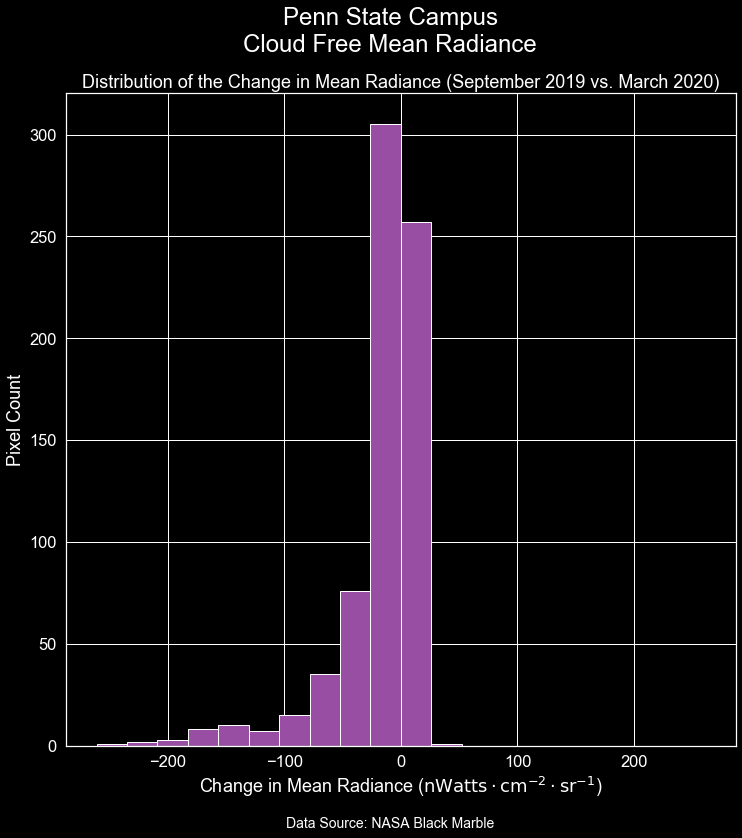

In [37]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        radiance_diff_sept2019_march2020,
        #         bins=40,
        hist_range=(radiance_diff_sept2019_march2020.min(), -radiance_diff_sept2019_march2020.min()),
        colors='#984ea3',
        title='Distribution of the Change in Mean Radiance (September 2019 vs. March 2020)',
        xlabel='Change in Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)', ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

plt.savefig(
    fname="penn-state-mean-radiance-change-sept2019-mar2020-histogram.png", 
    facecolor='k', dpi=300, transparent=True, bbox_inches='tight')

## Data Export

In [38]:
# Define export output paths
sept_2019_radiance_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-sept2019.tif")

march_2020_radiance_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-march2020.tif")

radiance_diff_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-difference-sept2019-march2020.tif")

In [39]:
# Define export transform
transform = from_origin(lon_min, lat_max, coord_spacing, coord_spacing)

# Define export metadata
psu_campus_metadata = {
    "driver": "GTiff",
    "dtype": radiance_diff_sept2019_march2020.dtype,
    "nodata": 0,
    "width": radiance_diff_sept2019_march2020.shape[1],
    "height": radiance_diff_sept2019_march2020.shape[0],
    "count": 1,
    "crs": psu_lat_lon_gdf.crs,  # +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs
    "transform": transform
}

In [40]:
# Export September 2019 radiance
export_to_geotiff(
    array=sept_2019_mean_radiance,
    output_path=sept_2019_radiance_outpath,
    metadata=psu_campus_metadata)

# Export March 2020 radiance
export_to_geotiff(
    array=march_2020_mean_radiance,
    output_path=march_2020_radiance_outpath,
    metadata=psu_campus_metadata)

# Export radiance difference
export_to_geotiff(
    array=radiance_diff_sept2019_march2020,
    output_path=radiance_diff_outpath,
    metadata=psu_campus_metadata)

Exported C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\04-graphics-outputs\penn-state-campus-radiance-sept2019.tif
Exported C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\04-graphics-outputs\penn-state-campus-radiance-march2020.tif
Exported C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\04-graphics-outputs\penn-state-campus-radiance-difference-sept2019-march2020.tif
